Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Plotting
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/Spaceship Titanic/train.csv")
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
len(df)

8693

In [4]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [5]:
# HomePlanet, CyroSleep, Cabin, Destination, Name
# all dtype objects can be missing
missing_imputer = make_pipeline(
    (SimpleImputer(strategy="constant", fill_value="missing")),
    (OneHotEncoder(handle_unknown="ignore"))
)

In [6]:
# Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
# all dtype floats can be median
numerical_imputer = make_pipeline(
    (SimpleImputer(strategy="median"))
)

In [7]:
# Run them through the preproccesor
preprocessor = make_column_transformer(
    (missing_imputer, make_column_selector(dtype_include=object)),
    (numerical_imputer, make_column_selector(dtype_include=np.number)),
    remainder="passthrough"
)

In [8]:
# Get the data ready
df.Transported = df.Transported.astype(int)
df.CryoSleep = df.CryoSleep.astype(str)
df.VIP = df.VIP.astype(str)

X = df.drop("Transported", axis=1)
y = df["Transported"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [9]:
# Lets get all the models we want to test
# Lets try Linear svc
# Svc
# Random forest
# MPL classifier 
# KNeighbors

models_dict = {
    "Linear SVC": LinearSVC(dual="auto", max_iter=3000),
    "SVC": SVC(),
    "Random Forest Classifier": RandomForestClassifier(n_jobs=-1),
    "MPL Classifier": MLPClassifier(),
    "KNearest Neighbors": KNeighborsClassifier(n_jobs=-1)
}
models_score = {}

In [10]:
for model_name, model in models_dict.items():
    model = make_pipeline(preprocessor, model)
    model.fit(X_train, y_train)
    models_score[model_name] = model.score(X_test, y_test)

C:\Users\Panache Branding\miniconda3\envs\new_env\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [11]:
models_score

{'Linear SVC': 0.7388803680981595,
 'SVC': 0.7879601226993865,
 'Random Forest Classifier': 0.7914110429447853,
 'MPL Classifier': 0.7645705521472392,
 'KNearest Neighbors': 0.7802914110429447}

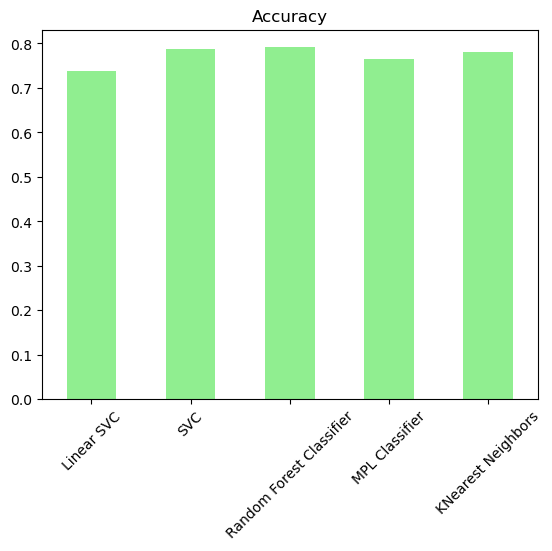

In [22]:
models_score_df = pd.DataFrame(models_score, index=[0])
models_score_df.T.plot(kind="bar", color="lightgreen", legend=False)
plt.title("Accuracy")
plt.xticks(rotation=45);

In [12]:
# RandomForestClassifier Seems to have the highest score. 
